# TP1: QUERIES AVANÇADAS
**Felipe Guimarães**

In [34]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
conn= sqlite3.connect('tp1.db')
cursor= conn.cursor()

In [ ]:
f= io.open('despesas_publicas_tp1.sql', 'r')
sql= f.read()
cursor.executescript(sql)

In [37]:
df= pd.read_sql_query("SELECT * FROM ORGAO ORDER BY QTD_ORGAOS_SUBORDINADOS DESC", conn)
df

,COD_ORGAO,NOME_ORGAO,QTD_ORGAOS_SUBORDINADOS
0,26000,Ministério da Educação,104
1,30000,Ministério da Justiça e Segurança Pública,6
2,22000,"Ministério da Agricultura, Pecuária e Abastec",5
3,24000,"Ministério da Ciência, Tecnologia, Inovações",4
4,52000,Ministério da Defesa,4
5,53000,Ministério da Integração Nacional,4
6,25000,Ministério da Fazenda,3
7,36000,Ministério da Saúde,3
8,20000,Presidência da República,2
9,39000,"Ministério dos Transportes, Portos e Aviação",2


In [38]:
df = pd.read_sql_query("SELECT P.NOME_PROGRAMA_GOVERNO, SUM(D.VALOR_DESPESA) AS VALOR_DESPESA " + 
                       "FROM DESPESA_PUBLICA AS D " +
                       "INNER JOIN PROGRAMA_GOVERNO AS P " +
                       "ON D.COD_PROGRAMA_GOVERNO = P.COD_PROGRAMA_GOVERNO " + 
                       "GROUP BY P.NOME_PROGRAMA_GOVERNO " +
                       "HAVING SUM(VALOR_DESPESA) > 0 " +
                       "ORDER BY VALOR_DESPESA DESC", conn)
df

,NOME_PROGRAMA_GOVERNO,VALOR_DESPESA
0,BRASIL SEM MISERIA,387175.60
1,ENEM,334262.06
2,PRONATEC,60262.46
3,CONTROLE DO CANCER,38971.19
4,MAIS MEDICOS,14400.00
5,REGULARIZACAO FUNDIARIA,1497.26
6,REDE CEGONHA,1210.00


In [39]:
df = pd.read_sql_query("SELECT D.MES_DESPESA, SUM(D.VALOR_DESPESA) AS VALOR_DESPESA " + 
                       "FROM DESPESA_PUBLICA AS D " +
                       "INNER JOIN DETALHAMENTO_FUNCAO AS DF " +
                       "ON D.COD_DETALHAMENTO = DF.COD_DETALHAMENTO " +
                       "INNER JOIN FUNCAO AS F " +
                       "ON DF.COD_FUNCAO = F.COD_FUNCAO " +
                       "WHERE F.NOME_FUNCAO = 'Educação' " +
                       "GROUP BY D.MES_DESPESA " +
                       "ORDER BY D.MES_DESPESA", conn)
df

,MES_DESPESA,VALOR_DESPESA
0,1,7000.00
1,2,0.00
2,3,0.00
3,4,18178.00
4,5,28073.08
5,6,135.36
6,7,0.00
7,8,3126.00
8,9,334126.70
9,10,385.38


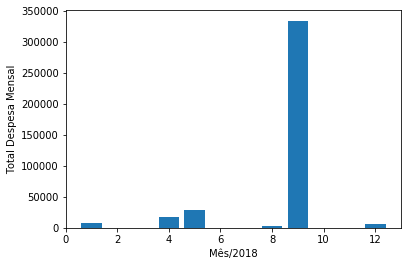

In [40]:
plt.bar(df['MES_DESPESA'].tolist(), df['VALOR_DESPESA'].tolist())

plt.xlabel("Mês/2018")
plt.ylabel("Total Despesa Mensal")
plt.show()

**1. Liste todos os códigos e nomes de funções da subfunção que possui o maior número de funções.**


In [42]:
df= pd.read_sql_query("SELECT cod_funcao, nome_funcao FROM Funcao NATURAL JOIN Detalhamento_Funcao "+
                      "WHERE cod_subfuncao IN (SELECT cod_subfuncao FROM (SELECT cod_subfuncao, MAX(NRO_FUNCAO) "+
                          "FROM (SELECT cod_subfuncao, COUNT(cod_funcao) NRO_FUNCAO FROM "+
                              "Funcao NATURAL JOIN Detalhamento_Funcao GROUP BY cod_subfuncao)))", conn)
df

,COD_FUNCAO,NOME_FUNCAO
0,5,Defesa nacional
1,6,Segurança pública
2,26,Transporte


**2. Liste a média de despesas públicas por função (nome) e subfunção (nome), apenas nos casos em que a média excedeu mil reais.**

In [43]:
df= pd.read_sql_query("SELECT nome_funcao, nome_subfuncao, avg(valor_despesa) AS MEDIA_DESPESAS "+
                      "FROM (Subfuncao NATURAL JOIN Detalhamento_Funcao NATURAL JOIN Funcao) "+
                      "NATURAL JOIN Despesa_Publica GROUP BY cod_funcao, cod_subfuncao HAVING avg(valor_despesa)>1000", conn)
df

,NOME_FUNCAO,NOME_SUBFUNCAO,MEDIA_DESPESAS
0,Assistência social,Tecnologia da informação,2266.087692
1,Assistência social,Assistência comunitária,1713.411805
2,Educação,Ensino profissional,1826.135152
3,Educação,Educação básica,4398.185000


**7. Liste os programas de governo e a quantidade de órgãos governamentais distintos envolvidos nas despesas públicas desses programas. Nesta consulta, desconsidere valores de despesa negativos ou iguais a zero no período.**

In [44]:
df= pd.read_sql_query("SELECT nome_programa_governo, count(cod_orgao) as NUMERO_ORGAOS, valor_despesa "+
                      "FROM Orgao NATURAL JOIN Despesa_Publica NATURAL JOIN Programa_Governo " +
                      "WHERE valor_despesa>0 GROUP BY cod_programa_governo", conn)
df

,NOME_PROGRAMA_GOVERNO,NUMERO_ORGAOS,VALOR_DESPESA
0,REDE CEGONHA,1,1210.00
1,CONTROLE DO CANCER,1,38971.19
2,ENEM,2,135.36
3,PRONATEC,7,5000.00
4,BRASIL SEM MISERIA,6,8215.70
5,REGULARIZACAO FUNDIARIA,1,1497.26
6,MAIS MEDICOS,3,2400.00


**9. Liste todas as despesas públicas (código da despesa, mês e ano da despesa, modalidade, valor) em que o órgão responsável é aquele que possui um número de órgãos subordinados maior do que a média.**

In [45]:
df= pd.read_sql_query("SELECT cod_despesa, mes_despesa, ano_despesa, modalidade_despesa, valor_despesa, cod_orgao "+
                      "FROM Despesa_Publica WHERE cod_orgao IN "+
                          "(SELECT cod_orgao FROM Orgao WHERE qtd_orgaos_subordinados > "+
                          "(SELECT AVG(qtd_orgaos_subordinados) FROM Orgao))", conn)
df

,COD_DESPESA,MES_DESPESA,ANO_DESPESA,MODALIDADE_DESPESA,VALOR_DESPESA,COD_ORGAO
0,196,10,2018,Reserva de Contingência,0.0,26000
1,197,1,2018,Reserva de Contingência,0.0,26000
2,198,2,2018,Reserva de Contingência,0.0,26000
3,199,3,2018,Reserva de Contingência,0.0,26000
4,200,4,2018,Reserva de Contingência,0.0,26000
5,201,5,2018,Reserva de Contingência,0.0,26000
6,202,6,2018,Reserva de Contingência,0.0,26000
7,203,7,2018,Reserva de Contingência,0.0,26000
8,204,9,2018,Reserva de Contingência,0.0,26000
9,205,10,2018,Reserva de Contingência,0.0,26000


**10. Liste todas as despesas públicas (código da despesa, mês e ano da despesa, modalidade, valor), ordenadas de forma decrescente pelo valor, em que o programa de governo é aquele que possui o maior valor total em despesas durante o ano de 2018.**

In [46]:
df= pd.read_sql_query("SELECT cod_despesa, mes_despesa, ano_despesa, modalidade_despesa, valor_despesa FROM Despesa_Publica "+
                      "WHERE ano_despesa=2018 AND cod_programa_governo IN (SELECT cod_programa_governo FROM "+
                            "(SELECT cod_programa_governo, MAX(SOMA) FROM (SELECT cod_programa_governo, "+
                                "SUM(valor_despesa) AS SOMA FROM Despesa_Publica GROUP BY cod_programa_governo)))"+
                      " ORDER BY valor_despesa DESC", conn)
df

,COD_DESPESA,MES_DESPESA,ANO_DESPESA,MODALIDADE_DESPESA,VALOR_DESPESA
0,1013,4,2018,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,219668.07
1,60,11,2018,Reserva de Contingência,81120.13
2,973,3,2018,Reserva de Contingência,58918.28
3,858,10,2018,Reserva de Contingência,19250.00
4,28,2,2018,Reserva de Contingência,8215.70
5,58,9,2018,Reserva de Contingência,3.42
6,0,11,2018,Reserva de Contingência,0.00
7,1,11,2018,Reserva de Contingência,0.00
8,2,12,2018,Reserva de Contingência,0.00
9,3,3,2018,Reserva de Contingência,0.00


**11. Liste os códigos e nomes dos órgãos governamentais relacionados ao programa de governo (ou programas, caso haja empate) que alcançou mais registros de despesas públicas durante o ano.**

In [49]:
df= pd.read_sql_query("SELECT DISTINCT cod_orgao, nome_orgao FROM Orgao NATURAL JOIN Despesa_Publica WHERE cod_programa_governo IN "+
                          "(SELECT cod_programa_governo FROM (SELECT cod_programa_governo, max(NRO_REGISTROS) FROM "+
                              "(SELECT cod_programa_governo, count(cod_programa_governo) as NRO_REGISTROS "+
                                  "FROM Despesa_Publica GROUP BY cod_programa_governo)))",conn)
df

,COD_ORGAO,NOME_ORGAO
0,20000,Presidência da República
1,22000,"Ministério da Agricultura, Pecuária e Abastec"
2,24000,"Ministério da Ciência, Tecnologia, Inovações"
3,25000,Ministério da Fazenda
4,26000,Ministério da Educação
5,36000,Ministério da Saúde
6,44000,Ministério do Meio Ambiente
7,52000,Ministério da Defesa
8,53000,Ministério da Integração Nacional
9,55000,Ministério do Desenvolvimento Social


***12. πNOME_FUNCAO, VALOR_DESPESA(FUNCAO ⋈ DETALHAMENTO FUNCAO ⋈ DESPESA PUBLICA)***


In [52]:
df= pd.read_sql_query("SELECT DISTINCT nome_funcao, valor_despesa "+
                      "FROM Funcao NATURAL JOIN Detalhamento_Funcao NATURAL JOIN Despesa_Publica", conn)
df

,NOME_FUNCAO,VALOR_DESPESA
0,Essencial à justiça,0.00
1,Defesa nacional,0.00
2,Segurança pública,0.00
3,Assistência social,0.00
4,Assistência social,58918.28
5,Assistência social,8215.70
6,Assistência social,219668.07
7,Assistência social,3.42
8,Assistência social,19250.00
9,Assistência social,81120.13


**13. πMODALIDADE_DESPESA, VALOR_DESPESA, NOME_ORGAO(ORGAO ⋈ σMODALIDADE_DESPESA = 'Reserva de Contingência'(DESPESA_PUBLICA))**


In [54]:
df= pd.read_sql_query("SELECT DISTINCT modalidade_despesa, valor_despesa, nome_orgao "+
                      "FROM Orgao NATURAL JOIN (SELECT * FROM Despesa_Publica "+
                      "WHERE modalidade_despesa= 'Reserva de Contingência')", conn)
df

,MODALIDADE_DESPESA,VALOR_DESPESA,NOME_ORGAO
0,Reserva de Contingência,0.00,Presidência da República
1,Reserva de Contingência,0.00,"Ministério da Agricultura, Pecuária e Abastec"
2,Reserva de Contingência,8215.70,"Ministério da Agricultura, Pecuária e Abastec"
3,Reserva de Contingência,3.42,"Ministério da Agricultura, Pecuária e Abastec"
4,Reserva de Contingência,81120.13,"Ministério da Agricultura, Pecuária e Abastec"
5,Reserva de Contingência,1497.26,"Ministério da Agricultura, Pecuária e Abastec"
6,Reserva de Contingência,0.00,"Ministério da Ciência, Tecnologia, Inovações"
7,Reserva de Contingência,0.00,Ministério da Fazenda
8,Reserva de Contingência,0.00,Ministério da Educação
9,Reserva de Contingência,1210.00,Ministério da Educação


**14. πVALOR_DESPESA,NOME_PROGRAMA_GOVERNO(DESPESA_PUBLICA ⋈ σNOME_PROGRAMA_GOVERNO='ENEM'(PROGRAMA_GOVERNO))**

In [55]:
df= pd.read_sql_query("SELECT DISTINCT valor_despesa, nome_programa_governo "+
                      "FROM Despesa_Publica NATURAL JOIN (SELECT * FROM Programa_Governo "+
                      "WHERE nome_programa_governo='ENEM')", conn)
df

,VALOR_DESPESA,NOME_PROGRAMA_GOVERNO
0,0.00,ENEM
1,135.36,ENEM
2,334126.70,ENEM


**15. πNOME_PROGRAMA_GOVERNO, QTD_ORGAOS_SUBORDINADOS, VALOR_DESPESA(DESPESA_PUBLICA ⋈ σNOME_ORGAO='Ministério da Educação'(ORGAO) ⋈ PROGRAMA_GOVERNO)**

In [56]:
df= pd.read_sql_query("SELECT DISTINCT nome_programa_governo, qtd_orgaos_subordinados, valor_despesa "+
                      "FROM Despesa_Publica NATURAL JOIN (SELECT * FROM Orgao "+
                      "WHERE nome_orgao= 'Ministério da Educação') NATURAL JOIN Programa_Governo", conn)
df

,NOME_PROGRAMA_GOVERNO,QTD_ORGAOS_SUBORDINADOS,VALOR_DESPESA
0,VIVER SEM LIMITE,104,0.00
1,MELHOR EM CASA,104,0.00
2,REDE CEGONHA,104,1210.00
3,REDE CEGONHA,104,0.00
4,CONTROLE DO CANCER,104,0.00
5,CIENCIA SEM FRONTEIRAS,104,0.00
6,ENEM,104,0.00
7,ENEM,104,135.36
8,PROVA BRASIL,104,0.00
9,PRONATEC,104,0.00


In [57]:
conn.close()